In [46]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

In [47]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.autolayout'] = True  # Ensures proper spacing
# Set equal aspect ratio and axis limits in the plotting code instead of rcParams

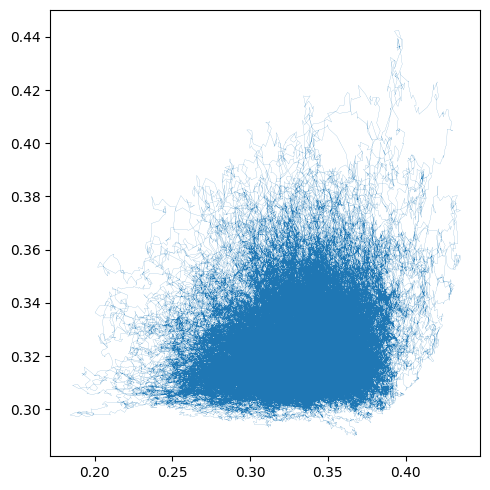

0.33075684455500104 0.3230002390299779


In [48]:
# with open('data/exp_list_0.csv', mode ='r') as file: # "ElsieWiddowsonFileC051.txt"
#     lines = file.readlines()
#     lines = [[float(i) for i in line.split(",")] for line in lines]



with open('data/Real/293_2/293-2mA_20k_10s_3u_10-29_2.txt', mode ='r') as file: # "ElsieWiddowsonFileC051.txt"
    lines = file.readlines()
    lines = [[float(i) for i in line.split("\t")] for line in lines]

# print(lines)

lines = np.array(lines)
plt.plot(lines[:,0], lines[:,1], lw=0.1)
plt.show()


avgx = sum(lines[:,0] / len(lines))
avgy = sum(lines[:,1] / len(lines))

print(avgx, avgy)


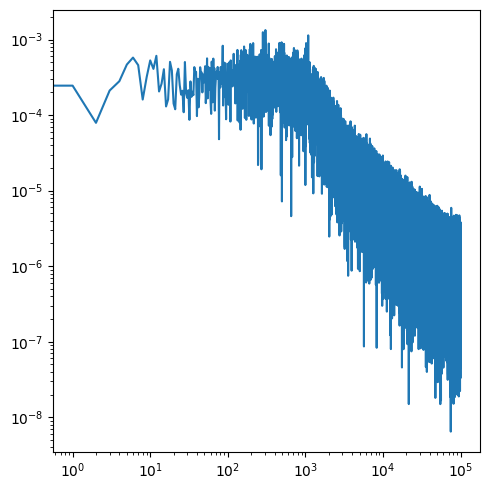

In [49]:
dists = np.sqrt((lines[:,0] - avgx) ** 2 + (lines[:,1] - avgy) ** 2)
freqs = scipy.fft.fft(dists) / len(dists)
plt.loglog(abs(freqs[100:10**5]))

In [50]:
import os
import glob

# Get all txt files in xyscan directory, excluding Settings files
currents = [100, 142, 193, 292, 392, 493]  # List of currents to process, 
xyscan_files = []
for current in currents:
    xyscan_files.extend([f for f in glob.glob(f'data/Real/xyscan/{current}-*.txt')
                        if not (f.endswith('Settingsx.txt') or f.endswith('Settingsy.txt') or 
                               f.endswith('SettingsX.txt') or f.endswith('SettingsY.txt'))])

all_data = []
for filename in xyscan_files:
    with open(filename, mode='r') as file:
        lines = file.readlines()
        # Convert each line into list of floats by splitting on tabs
        data = [[float(val) for val in line.strip().split('\t')] for line in lines]
        # Transpose to get columns 
        data = list(map(list, zip(*data)))

    print(f"Processing {filename}:")
    all_data += [data]
    # print(data)

    # plt.figure()
    # plt.plot(np.arange(len(data[0])), data[0], label = 'x data')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[1])), data[1], label = 'y data')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[2])), data[2], label = 'x data strain')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[3])), data[3], label = 'y data strain')
    # plt.title(os.path.basename(filename))
    # plt.legend()
    # plt.show()

all_data = np.array(all_data)


Processing data/Real/xyscan/100-6mA_xx.txt:
Processing data/Real/xyscan/100-6mA_yy.txt:
Processing data/Real/xyscan/142-4mA_yy.txt:
Processing data/Real/xyscan/142-4mA_xx.txt:
Processing data/Real/xyscan/193-5mA_xx.txt:
Processing data/Real/xyscan/193-4mA_yy.txt:
Processing data/Real/xyscan/292-1mA_yy.txt:
Processing data/Real/xyscan/292-1mA_xx.txt:
Processing data/Real/xyscan/392-9mA_yy.txt:
Processing data/Real/xyscan/392-8mA_XX.txt:
Processing data/Real/xyscan/493-3mA_xx.txt:


In [51]:
# Need to now find the part of the peaks where we fit a line for calibrating the QPD.
print(len(xyscan_files), len(all_data))
xyscan_files = [f.split("/")[-1] for f in xyscan_files]

11 11


193-4mA_yy.txt 1


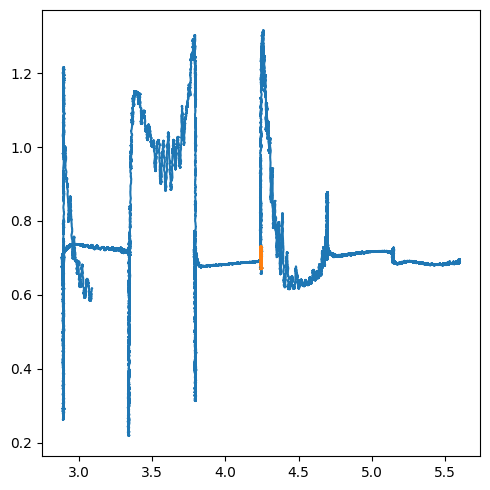

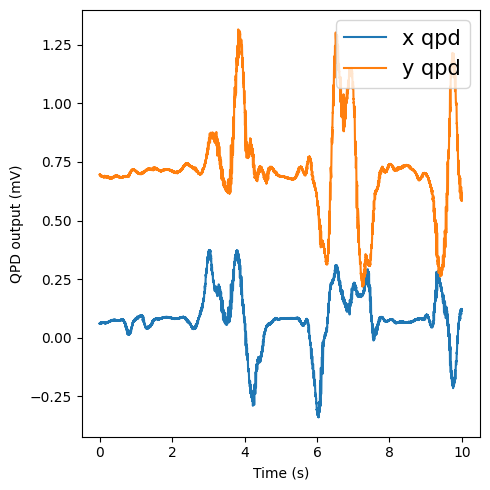

In [61]:
ind = 5
print(xyscan_files[ind], 1 if 'y' in xyscan_files[ind] or 'Y' in xyscan_files[ind] else 0)
specific = all_data[ind][1]
# plt.plot(range(len(specific)), specific)
plt.plot(all_data[ind][2], specific)
plt.plot(all_data[ind][2][87500:91500], specific[87500:91500])
plt.show()
# plt.plot(range(len(specific))[87500:91500], specific[87500:91500])
# popt, perr, chisq, yfit = fitlin(all_data[ind][2][87500:91500], specific[87500:91500], np.array([0]*(91500-87500)))
# print(popt, perr)
plt.plot(np.arange(len(all_data[ind][0])) / 2e4, all_data[ind][0] * 10 / 10, label='x qpd')
plt.plot(np.arange(len(all_data[ind][0])) / 2e4, all_data[ind][1] * 10 / 10, label='y qpd')
plt.xlabel('Time (s)')
plt.ylabel('QPD output (mV)')
# plt.plot(all_data[ind][2], label='x stage')
# plt.plot(all_data[ind][3], label='y stage')
# line_fit_intervals = [[[92000,101500]], [165000,169000], [153500,157500]]
plt.legend(loc="upper right",fontsize=15,ncol = 1)
line_fit_intervals = {'0,1'}

In [53]:
xx = {'100': (-0.00202372,	-0.00246727), '193': (-0.00656128,	-0.01077355), '292': (-0.011165,	-0.02091801), '392': (-0.01130522,	-0.02648227)}
# xx_series = pd.Series(data=xx) 
yy = {'100': (-0.00109493,	-0.00179321), '193': (-0.004255306,	-0.00838348), '292': (-0.00843359,	-0.0218029), '392': (-0.012513,	-0.0267312)}
# yy_series = pd.Series(data=yy)

In [54]:
scaling_factor = 50/20000
xx = np.array([-0.00202372, -0.00656128, -0.011165, -0.01130522])
xy = np.array([-0.00246727, -0.01077355, -0.02091801, -0.02648227])
yx = np.array([-0.00109493, -0.004255306, -0.00843359, -0.012513])
yy = np.array([-0.00179321, -0.00838348, -0.0218029, -0.0267312])

In [55]:
tantheta1 = yx/xx
tantheta2 = xy/yy

In [56]:
print(np.arctan(tantheta1) * 180/np.pi, np.arctan(tantheta2)* 180/np.pi)

[28.41552301 32.96535078 37.06592557 47.90288172] [53.99037373 52.11159119 43.81338639 44.73197511]
